# Active Learning for Text Classification using Small-Text
## 02 - Stopping Criteria

This tutorial shows how to use stopping criteria when performing active learning for text classification using [small-text](https://github.com/webis-de/small-text). If you have read the previous notebook already, you can also directly jump to the [relevant parts for stopping criteria](#Stopping-Criterion).


### Installation and Preparation

Besides small-text, we also install [datasets](https://github.com/huggingface/datasets) to load an example dataset and [matptlotlib](https://matplotlib.org/) to plot the learning curves at the end.

In [1]:
%pip install small-text[transformers]==1.0.0b2   # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

Obtaining small-text[transformers] from git+https://github.com/webis-de/small-text@27bde69be30aae286304def584b3a269ab96e35d#egg=small-text[transformers]
  Skipping because already up-to-date.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: small-text
    Found existing installation: small-text 1.0.0a8
    Uninstalling small-text-1.0.0a8:
      Successfully uninstalled small-text-1.0.0a8
  Running setup.py develop for small-text
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


The code in the following cell sets the logging level and progress bars to make it suitable for notebooks. Moreover, we set a fixed random seed, so you get the same output every time you run this notebook.

In [2]:
import datasets
import torch

import numpy as np

from matplotlib import rcParams

datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

# set matplotlib params
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

# fix the random seed
seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

### Loading and Preparing the Data

Again, we load the rotten tomatoes dataset and build a TransformersDataset object which is then used for active learning.

In [3]:
import logging
import numpy as np


from transformers import AutoTokenizer

from small_text.integrations.transformers.datasets import TransformersDataset


# helper function from the previous notebook
def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)



raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]


transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

train = get_transformers_dataset(tokenizer, raw_dataset['train']['text'], raw_dataset['train']['label'])
test = get_transformers_dataset(tokenizer, raw_dataset['test']['text'], raw_dataset['test']['label'])

### Active Learning

Now we setup a tranformer-based active learning process.

In [4]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.integrations.transformers import TransformerModelArguments


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):
    

    x_indices_initial = random_initialization_balanced(y_train, n_samples=20)
    y_initial = y_train[x_indices_initial]

    active_learner.initialize_data(x_indices_initial, y_initial)

    return x_indices_initial



transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
labeled_indices = initialize_active_learner(active_learner, train.y)

### Stopping Criterion

Besides, we slightly change the evaluation: In order to make the setting more realistic, we do not evaluate on the test accuracy any longer, since you will not have a test set in real-world situations. 

Unlike before, we now also output the stopping response (True or False). The stopping criteria are not bound to the PoolBasedActiveLearner class because in real-world applications a user should have the final say whether the active learning process is stopped or not. Stopping criteria are intended to be an indicator, whose recommendation can be accepted or rejected.

In [5]:
from sklearn.metrics import accuracy_score
from small_text.stopping_criteria import KappaAverage


num_queries = 15
stopping_criterion = KappaAverage(num_classes, kappa=0.9)


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    # Notice: We observe the train accuracy now.
    train_acc = accuracy_score(y_pred, train.y)

    print('Train accuracy: {:.2f}'.format(train_acc))
    print('Test accuracy: {:.2f}'.format(accuracy_score(y_pred_test, test.y)))
    
    return train_acc


results = []
stopping_history = []

results.append(evaluate(active_learner, train[labeled_indices], test))
stopping_history.append(stopping_criterion.stop(predictions=active_learner.classifier.predict(train)))


for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    q_indices = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    labeled_indices = np.concatenate([q_indices, labeled_indices])
    
    print('---------------')
    print(f'Iteration #{i} ({len(labeled_indices)} samples)')
    results.append(evaluate(active_learner, train[labeled_indices], test))
    
    stopping_criterion_response = stopping_criterion.stop(predictions=active_learner.classifier.predict(train))
    print(f'Stop: {stopping_criterion_response}')
    stopping_history.append(stopping_criterion_response)
 

Train accuracy: 0.60
Test accuracy: 0.49
---------------
Iteration #0 (40 samples)
Train accuracy: 0.97
Test accuracy: 0.57
Stop: False
---------------
Iteration #1 (60 samples)
Train accuracy: 0.83
Test accuracy: 0.57
Stop: False
---------------
Iteration #2 (80 samples)
Train accuracy: 0.96
Test accuracy: 0.59
Stop: False
---------------
Iteration #3 (100 samples)
Train accuracy: 0.97
Test accuracy: 0.72
Stop: False
---------------
Iteration #4 (120 samples)
Train accuracy: 0.97
Test accuracy: 0.67
Stop: False
---------------
Iteration #5 (140 samples)
Train accuracy: 0.97
Test accuracy: 0.74
Stop: False
---------------
Iteration #6 (160 samples)
Train accuracy: 0.99
Test accuracy: 0.76
Stop: True
---------------
Iteration #7 (180 samples)
Train accuracy: 0.97
Test accuracy: 0.70
Stop: False
---------------
Iteration #8 (200 samples)
Train accuracy: 0.96
Test accuracy: 0.76
Stop: False
---------------
Iteration #9 (220 samples)
Train accuracy: 0.98
Test accuracy: 0.73
Stop: False
---

### Visualization

You can use the learning curve plot, which now depicts the learning curve of the training accuracy, to visualize the earliest iteration at which the stopping criterion returned `True`.

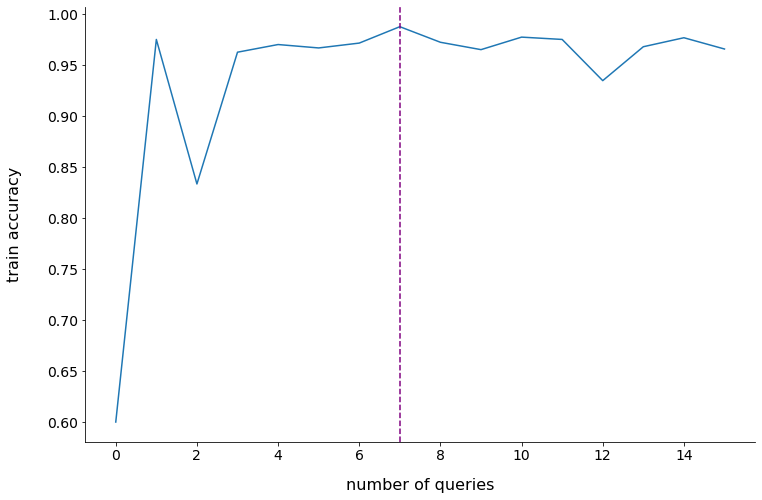

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('train accuracy', labelpad=25)

earliest_stopping_response = np.amin([i for i, _ in enumerate(stopping_history) if stopping_history[i] is True])
plt.axvline(x=earliest_stopping_response, ymin=0, ymax=1, color='purple', ls='--')

sns.despine()